## Modules

In [1]:
import pandas as pd
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from openai import OpenAI

## Data loading

In [22]:
documents_path = './data/'                            

# word frequency
word_freq_df = pd.DataFrame(columns=['word', 'frequency'])                
for csv_file in glob.glob(os.path.join(documents_path, '*/words_freq.csv')):                                                       
    df = pd.read_csv(csv_file)                                            
    word_freq_df = pd.concat([word_freq_df, df], ignore_index=True)       
                                                                            
# entity frequency
entity_freq_records = []                                                  
for json_file in glob.glob(os.path.join(documents_path, '*/entities.json')):                                                   
    with open(json_file, 'r') as f:                                       
        entities_freq = json.load(f)                                      
        for word, frequency in entities_freq.items():                     
            entity_freq_records.append({'entity': word, 'frequency': frequency})                                                                 
entity_freq_df = pd.DataFrame(entity_freq_records)  

word_freq_agg = word_freq_df.groupby('word', as_index=False).sum()                                                       
entity_freq_agg = entity_freq_df.groupby('entity', as_index=False).sum()                                                       

In [23]:
words_summary_statistics = {                                                    
    'total_words': word_freq_agg['word'].nunique(),                  
    'mean_frequency': word_freq_agg['frequency'].mean(),             
    'median_frequency': word_freq_agg['frequency'].median(),         
    'std_dev_frequency': word_freq_agg['frequency'].std(),           
    'min_frequency': word_freq_agg['frequency'].min(),               
    'max_frequency': word_freq_agg['frequency'].max(),               
}                                                                         

entities_summary_statistics = {
    'total_entities': entity_freq_agg['entity'].nunique(),
    'mean_frequency': entity_freq_agg['frequency'].mean(),
    'median_frequency': entity_freq_agg['frequency'].median(),
    'std_dev_frequency': entity_freq_agg['frequency'].std(),
    'min_frequency': entity_freq_agg['frequency'].min(),
    'max_frequency': entity_freq_agg['frequency'].max(),
}
                                                                            
print("Summary Statistics for the Number of Words:")                       
for stat, value in words_summary_statistics.items():                            
    print(f"{stat}: {value}")                                             

print("\nSummary Statistics for the Number of Entities:")
for stat, value in entities_summary_statistics.items():
    print(f"{stat}: {value}")
                                                                            

Summary Statistics for the Number of Words:
total_words: 25463
mean_frequency: 19.25605780937046
median_frequency: 2.0
std_dev_frequency: 359.3282027688957
min_frequency: 1
max_frequency: 41417

Summary Statistics for the Number of Entities:
total_entities: 3959
mean_frequency: 1.626673402374337
median_frequency: 1.0
std_dev_frequency: 4.407038311875891
min_frequency: 1
max_frequency: 156


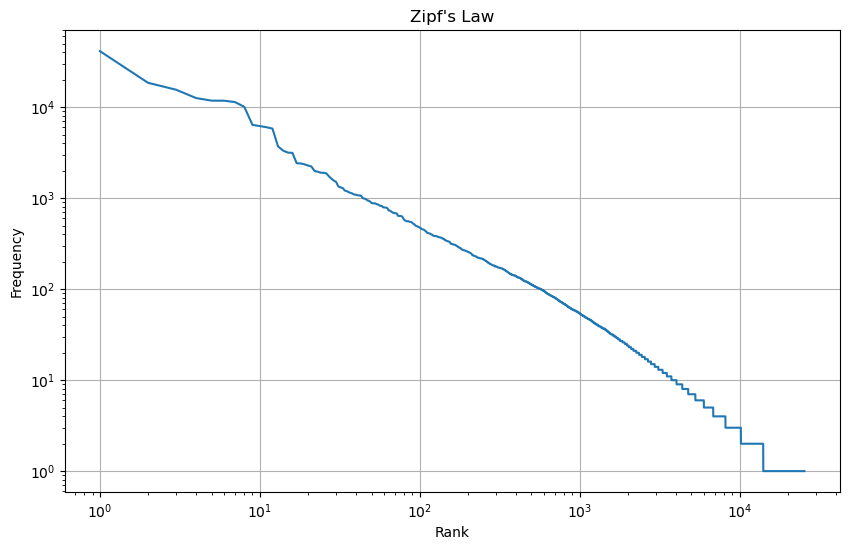

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vlermanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


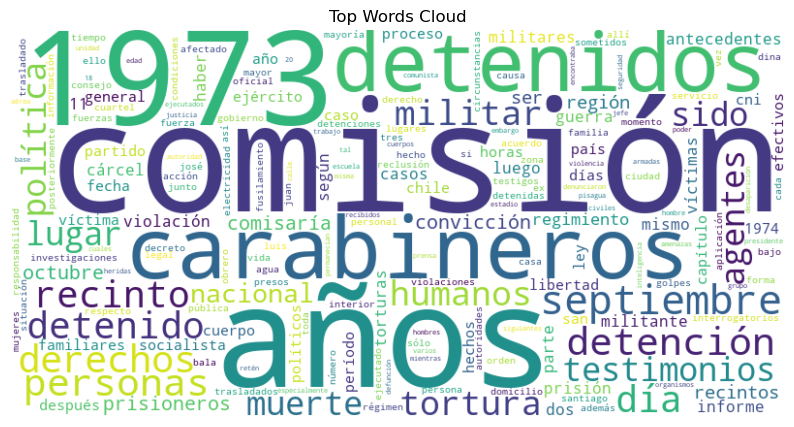

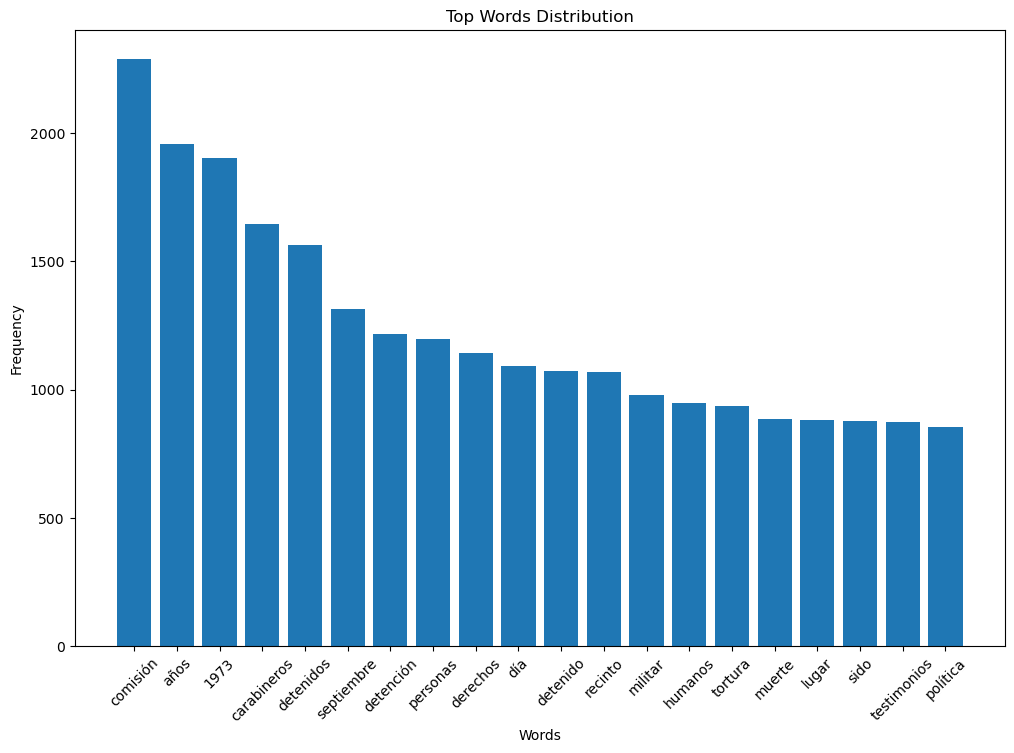

In [31]:
# Zipf's Law                                                    
word_freq_agg = word_freq_agg.sort_values(by='frequency', ascending=False).reset_index(drop=True)                                     
word_freq_agg['rank'] = word_freq_agg.index + 1                 
                                                                        
plt.figure(figsize=(10, 6))                                               
plt.loglog(word_freq_agg['rank'],word_freq_agg['frequency'])   
plt.xlabel('Rank')                                                        
plt.ylabel('Frequency')                                                   
plt.title("Zipf's Law")                                                   
plt.grid(True)                                                            
plt.show()                                                                
                                                                        
nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('spanish'))
word_df = word_freq_agg[~word_freq_agg['word'].isin(spanish_stop_words)]    
word_df = word_df[word_df['word'].str.len() > 1]
                                                                        
# Word Cloud                                                              
wordcloud = WordCloud(width=800, height=400,                              
background_color='white').generate_from_frequencies(                        
    dict(zip(word_df['word'], word_df['frequency']))    
)                                                                         
                                                                        
plt.figure(figsize=(10, 6))                                               
plt.imshow(wordcloud, interpolation='bilinear')                           
plt.axis('off')                                                           
plt.title('Top Words Cloud')                                              
plt.show()                                                                

# Distribution of Top Words
top_words_df = word_df.head(20)  # Adjust the number of top words
                                                                        
plt.figure(figsize=(12, 8))                                               
plt.bar(top_words_df['word'], top_words_df['frequency'])                  
plt.xlabel('Words')                                                       
plt.ylabel('Frequency')                                                   
plt.title('Top Words Distribution')                                       
plt.xticks(rotation=45)                                                   
plt.show()  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vlermanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


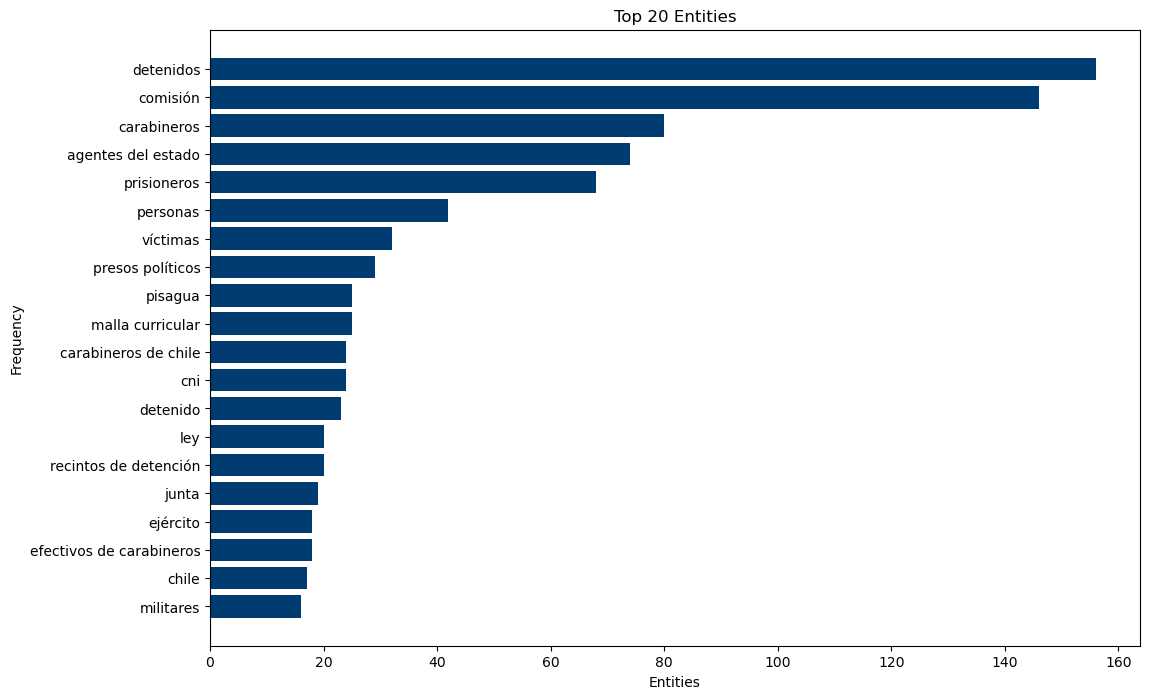

In [50]:
entity_df = entity_freq_agg[entity_freq_agg['entity'] != 'n/a']
entity_df = entity_df[entity_df['entity'] != 'N/A']
nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('spanish'))
entity_df = entity_df[~entity_df['entity'].isin(spanish_stop_words)]    
entity_df = entity_df[entity_df['entity'].str.len() > 1]
num = 20
top_entities_df = entity_df.sort_values(by='frequency', ascending=False).head(num)
top_entities_df = top_entities_df.sort_values(by='frequency', ascending=True)
                                                                            
plt.figure(figsize=(12, 8))                                               
plt.barh(top_entities_df['entity'], top_entities_df['frequency'], color='#003c71')            
plt.xlabel('Entities')                                                    
plt.ylabel('Frequency')                                                   
plt.title(f'Top {num} Entities')                                                 
plt.show()

In [37]:
top_entities_df

,entity,frequency
1092,detenidos,156
783,comisión,146
540,carabineros,80
242,agentes del estado,74
3045,prisioneros,68
2934,personas,42
3898,víctimas,32
3025,presos políticos,29
2959,pisagua,25
2397,malla curricular,25


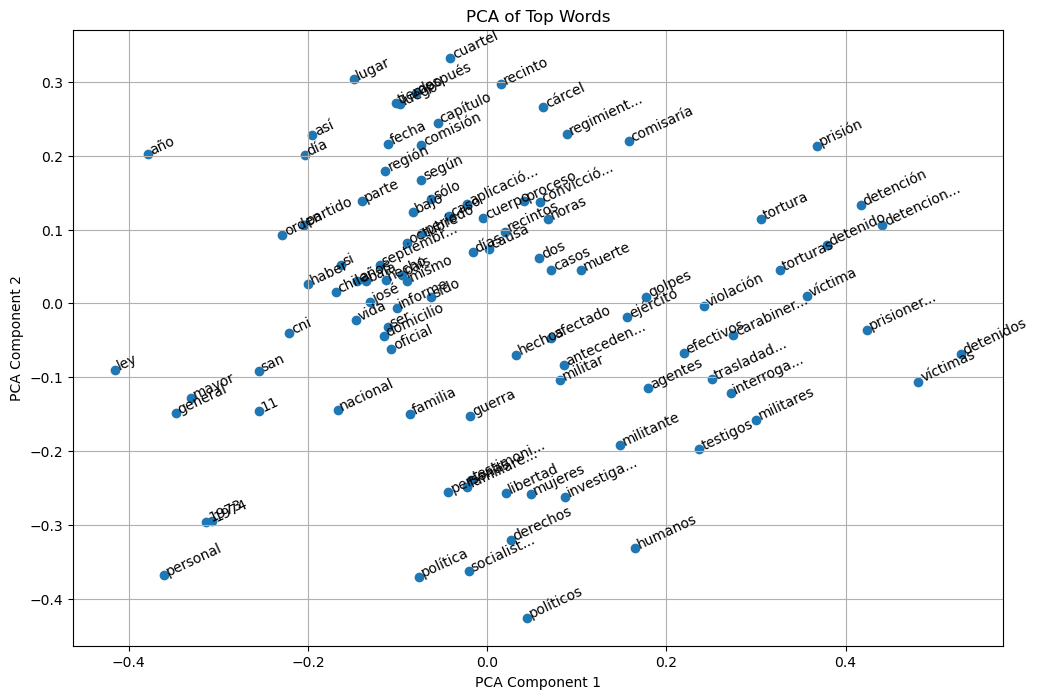

In [64]:
key = str(os.getenv('OPENAI_API_KEY'))
client = OpenAI(api_key=key)
dims = 200

def get_word_embedding(word):
    vector_repr = client.embeddings.create(
        input=word,
        model="text-embedding-3-small",
        dimensions=dims
    )
    return vector_repr.data[0].embedding
                                                                          
# Dimensionality Reduction Scatterplot of Top Words             
top_words_df = word_df.sort_values(by='frequency', ascending=False).head(100)
top_words = top_words_df['word'].tolist()                                 
                                                                          
# Get embeddings for top words                                            
top_word_embeddings = np.array([get_word_embedding(word) for word in top_words])                                                                 
                                                                          
# Perform PCA                                                             
pca = PCA(n_components=2)                                                 
top_words_pca = pca.fit_transform(top_word_embeddings)                    
                                                                          
# Plot PCA results                                                        
plt.figure(figsize=(12, 8))                                               
plt.scatter(top_words_pca[:, 0], top_words_pca[:, 1])                     

def shorten_name(name, max_length=9):
    if len(name) > max_length:
        return name[:max_length] + '...'
    return name
                                                                          
for i, word in enumerate(top_words):                                      
    short_name = shorten_name(word)
    plt.annotate(short_name, (top_words_pca[i, 0], top_words_pca[i, 1]), rotation=25)
                                                                          
plt.title('PCA of Top Words')                                             
plt.xlabel('PCA Component 1')                                             
plt.ylabel('PCA Component 2')                                             
plt.grid(True)                                                            
plt.show()                                                                

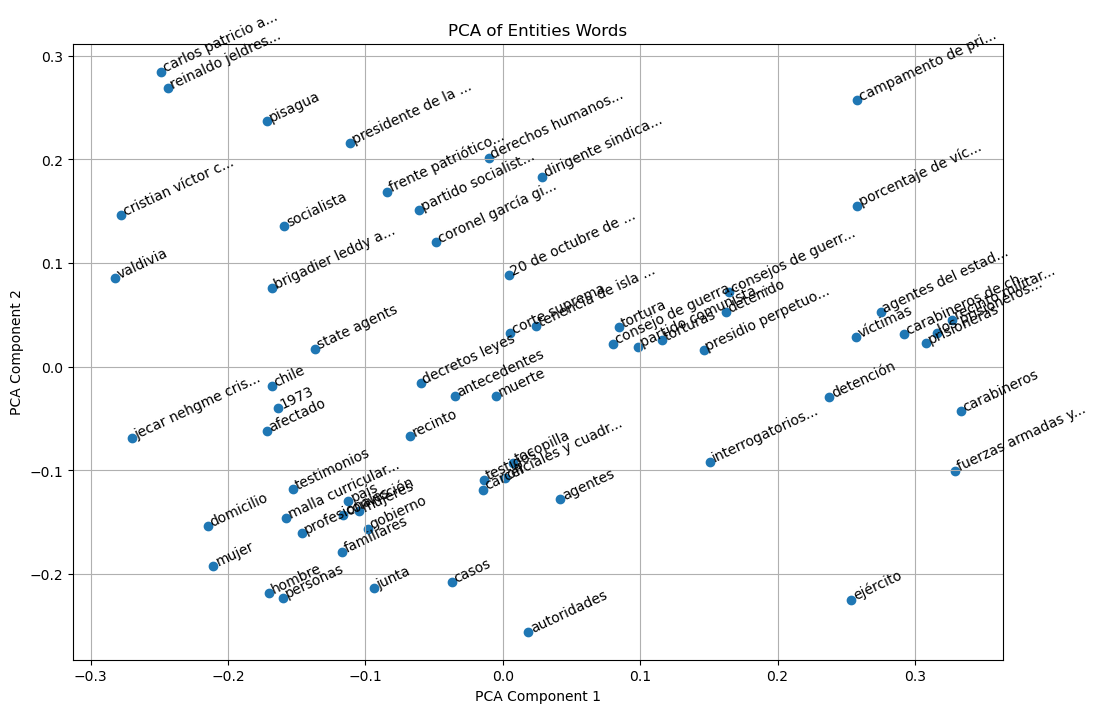

In [69]:
# Dimensionality Reduction Scatterplot of Entities Words        
top_entities_df = entity_df.sort_values(by='frequency', ascending=False).head(100)
# Adjust the number of top entities as needed                               
top_entities = top_entities_df['entity'].tolist()                           
                                                                          
# Get embeddings for top entities                                         
top_entity_embeddings = np.array([get_word_embedding(word) for word in top_entities])                                                              
                                                                          
# Perform PCA                                                             
top_entities_pca = pca.fit_transform(top_entity_embeddings)               

# Calcular los percentiles                                                                                                                                                                        
lower_percentile = 10
upper_percentile = 90
                                                                                                                                                                                                    
low_x, high_x = np.percentile(top_entities_pca[:, 0], [lower_percentile, upper_percentile])
low_y, high_y = np.percentile(top_entities_pca[:, 1], [lower_percentile, upper_percentile])
                                                                                                                                                                                                    
# Filtrar los puntos que están dentro de los percentiles                                                                                                                                          
mask = (top_entities_pca[:, 0] >= low_x) & (top_entities_pca[:, 0] <= high_x) \
    & (top_entities_pca[:, 1] >= low_y) & (top_entities_pca[:, 1] <= high_y)
                                                                                                                                                                                                    
filtered_pca = top_entities_pca[mask]                                                                                                                                                             
filtered_entities = np.array(top_entities)[mask]
                                                                          
# Plot PCA results                                                        
plt.figure(figsize=(12, 8))                                               
plt.scatter(filtered_pca[:, 0], filtered_pca[:, 1])               

def shorten_name(name, max_length=17):
    if (len(name)+3) > max_length:
        return name[:max_length] + '...'
    return name
                                                                          
for i, word in enumerate(filtered_entities):                                   
    short_name = shorten_name(word)
    plt.annotate(short_name, (filtered_pca[i, 0], filtered_pca[i, 1]), rotation=25)
                                                                         
plt.title('PCA of Entities Words')                                        
plt.xlabel('PCA Component 1')                                             
plt.ylabel('PCA Component 2')                                             
plt.grid(True)                                                            
plt.show()